In [130]:
%matplotlib nbagg

In [2]:
from planet4 import markings

In [3]:
id_ = 'bvc'
p4id = markings.ImageID(id_, scope='planet4')

## 4 ways to describe the same ellipse
Below I create the same ellipse 4 times just offset in `x` for display.
The differences are the 180 degree symmetry for any ellipse, plus a 90 degree symmetry when semi-major and -minor are exchanged.

In [4]:
d = dict(x=[280, 300, 320, 340], y=4*[300],
               angle=[85, 265, 175, -5],
               radius_1=[200, 200, 30, 30],
               radius_2=[30, 30, 200, 200])

In [5]:
df = pd.DataFrame(d)

<IPython.core.display.Javascript object>


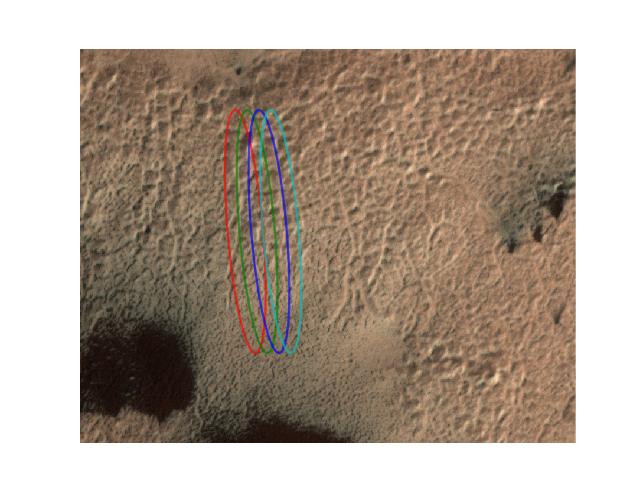

In [6]:
p4id.plot_blotches(blotches=df, lw=2)

What happened a while ago is that we realized one symmetry, but not the other. I then implemented an angle normalization like this:

In [7]:
df = df.assign(angle_new=df.angle%180)
df

,angle,radius_1,radius_2,x,y,angle_new
0,85,200,30,280,300,85
1,265,200,30,300,300,85
2,175,30,200,320,300,175
3,-5,30,200,340,300,175


This created the issue that the angles are now distributed with 180 degree difference, while the radii still were not sorted (some have radius_1 > radius_2, some the opposite).

For the 90 degree symmetry, we realized that we can normalize by sorting by radius and adding 90 degree, in case a swap was required:

In [8]:
def normalize_radii(df, angle_col='angle'):
    data = df.copy()
    idx = data.radius_1 < data.radius_2
    col_orig = ['radius_1','radius_2']
    col_reversed = list(reversed(col_orig))
    data.loc[idx, col_orig] = data.loc[idx, col_reversed].values
    data.loc[idx, angle_col] -= 90
    return data

In [11]:
normed = normalize_radii(df, 'angle')
normed

,angle,radius_1,radius_2,x,y,angle_new
0,85,200,30,280,300,85
1,265,200,30,300,300,85
2,85,200,30,320,300,175
3,-95,200,30,340,300,175


Applying the 180 degree normalization at this point should provide us with normalized ellipses, that can be clustered together:

In [13]:
normed.angle = normed.angle % 180

In [14]:
normed

,angle,radius_1,radius_2,x,y,angle_new
0,85,200,30,280,300,85
1,85,200,30,300,300,85
2,85,200,30,320,300,175
3,85,200,30,340,300,175


## Testing thoroughly though...
To test this repair more thoroughly, I create all 4 identical ellipses for 3 slightly offset-drawn ellipses, each for a blotch with semi-major axis around 0, around 45 degree and around 90, where I presume mathematical issues could occur.

Hence I will create 4 blotches for a -2, 4 for a 0 and 4 for a +2 alignment, and after correction, they should all show the same angle.
Same for the blotches at 45 and 90 degrees angle.

In [15]:
x=[280, 300, 320, 340]
y=4*[300]
angle=[85, 265, 175, -5]
radius_1=[200, 200, 30, 30]
radius_2=[30, 30, 200, 200]

In [16]:
angle_groups = [[-2,0,2], [43,45,47],[88,90, 92]]
y_loc = [500, 300, 100]
x_loc = 300

In [204]:
x = []
y = []
angle = []
rads1 = []
rads2 = []
for g, y_avg in zip(angle_groups, y_loc): 
    for angle_val in g:
        for offset,r1, r2 in zip([0, 180, 90, -90,], radius_1, radius_2):
            x.append(300+np.random.randint(-5,5))
            y.append(y_avg+np.random.randint(-5,5))
            angle.append(angle_val+offset)
            rads1.append(r1)
            rads2.append(r2)

In [205]:
df = pd.DataFrame(dict(x=x, y=y, angle=angle, radius_1=rads1,
                       radius_2=rads2))

In [206]:
df

,angle,radius_1,radius_2,x,y
0,-2,200,30,300,497
1,178,200,30,304,500
2,88,30,200,300,503
3,-92,30,200,302,498
4,0,200,30,297,502
5,180,200,30,296,496
6,90,30,200,297,502
7,-90,30,200,297,500
8,2,200,30,301,496
9,182,200,30,295,499


<IPython.core.display.Javascript object>


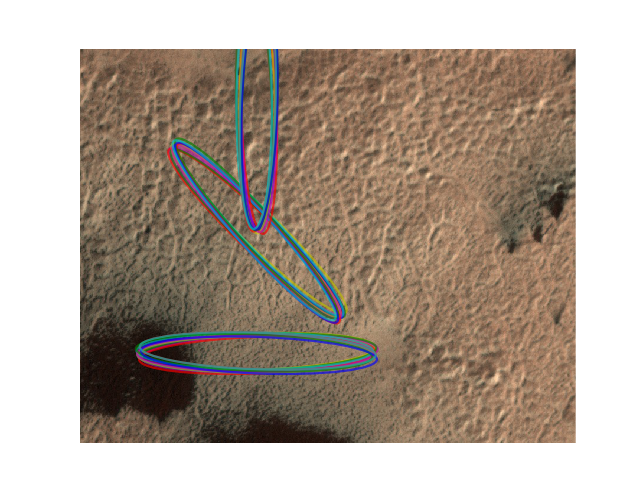

In [207]:
p4id.plot_blotches(blotches=df, lw=2)

In [208]:
normed = normalize_radii(df)

Plotting normalized angles, one can see that all ellipses are still the same.

<IPython.core.display.Javascript object>


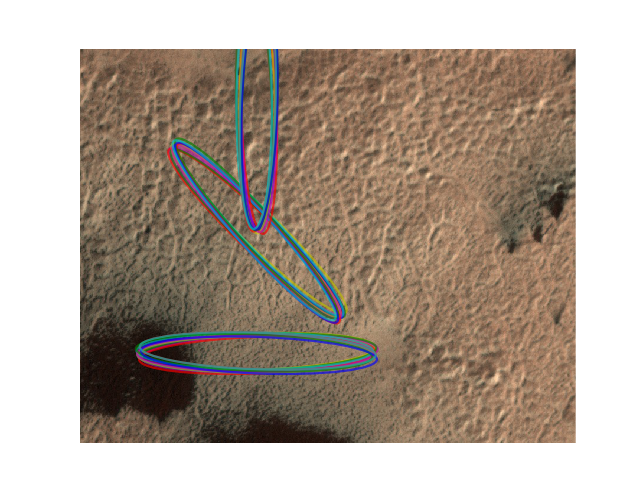

In [209]:
p4id.plot_blotches(blotches=normed, lw=2)

In [210]:
df.angle.values

array([ -2, 178,  88, -92,   0, 180,  90, -90,   2, 182,  92, -88,  43,
       223, 133, -47,  45, 225, 135, -45,  47, 227, 137, -43,  88, 268,
       178,  -2,  90, 270, 180,   0,  92, 272, 182,   2])

In [138]:
normed.angle.values

array([  -2,  178,   -2, -182,    0,  180,    0, -180,    2,  182,    2,
       -178,   43,  223,   43, -137,   45,  225,   45, -135,   47,  227,
         47, -133,   88,  268,   88,  -92,   90,  270,   90,  -90,   92,
        272,   92,  -88])

Doing a module operation on the radius-normalized angles solves almost everything, apart from the case around 0, where I would like to have 178 to be -2 (which of course can't be done using a module):

In [111]:
(normed.angle % 180).values

array([178, 178, 178, 178,   0,   0,   0,   0,   2,   2,   2,   2,  43,
        43,  43,  43,  45,  45,  45,  45,  47,  47,  47,  47,  88,  88,
        88,  88,  90,  90,  90,  90,  92,  92,  92,  92])

After long deliberation and wasting Anya's afternoon as well, I came to the conclusion that clustering on the sine value of the angle is actually okay. (And I already realised that after/during Taiwan meeting, but did not have the full radius-based angle normalization in place then!)

In [235]:
np.sin(np.deg2rad(normed.angle%180)).values

array([ 0.0348995 ,  0.0348995 ,  0.0348995 ,  0.0348995 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.0348995 ,  0.0348995 ,
        0.0348995 ,  0.0348995 ,  0.68199836,  0.68199836,  0.68199836,
        0.68199836,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
        0.7313537 ,  0.7313537 ,  0.7313537 ,  0.7313537 ,  0.99939083,
        0.99939083,  0.99939083,  0.99939083,  1.        ,  1.        ,
        1.        ,  1.        ,  0.99939083,  0.99939083,  0.99939083,
        0.99939083])

Below, the three sets of blotches are clustering at 3 different locations in sine-space.

<IPython.core.display.Javascript object>


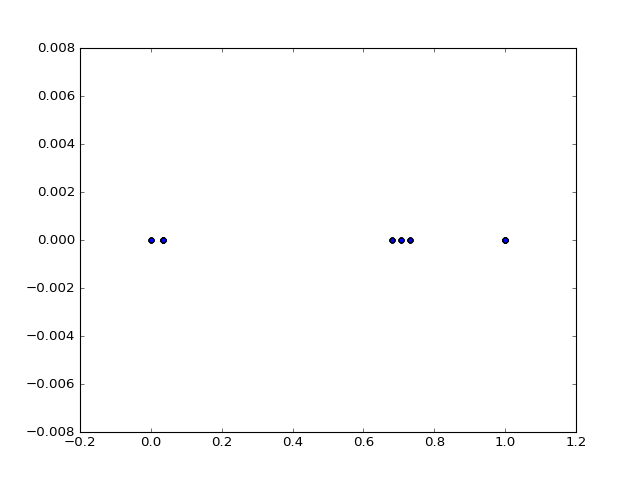

In [237]:
input_angles = (normed.angle%180)
y = np.sin(np.deg2rad(input_angles))
plt.figure();
plt.scatter(y, np.zeros_like(x));

Afterwards, having the indexes of what clustered together, I will be using the **ORIGINAL** angles of the clustered blotches for the average creation.

Fortunately, the `circmean` function can be told, what the wrap-around value is, so that will be 180 for blotch angles, and 360 for fans.

In [238]:
from scipy.stats import circmean

In [246]:
# this averages the first 12 objects that jitter around 0,
# so the average should be 0.
circmean(normed.angle[0:12]%180, high=180).round()

0.0